In [2]:
from utils_hasse import * 
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

from scipy import stats

import lightgbm as lgb
from catboost import CatBoostRegressor


# Util functions

## Extra functions

### Error function

In [3]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

### Plot importance

In [180]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## Preprocessing Data

In [29]:
def preprocess(data,price_outlier_rejection=False,fill=True):
    if price_outlier_rejection is True:
        data = data[(np.abs(stats.zscore(data['price'])) < 3.9)]
    if fill is True:
        return data.fillna(data.median())
    else:
        return data.dropna()

## Creating new features

### Polar coordinates
Instead of longitude and latitude, use the polar coordinates to represent the distance from the center

In [127]:
def polar_coordinates(data):
    # Make a copy
    data_normed_r = data.copy()

    # Move origin to centre
    data_normed_r['latitude'] = data_normed_r['latitude'] -  data_normed_r['latitude'].mean()
    data_normed_r['longitude'] = data_normed_r['longitude'] -  data_normed_r['longitude'].mean()
  
    # Convert to polar coordinates
    data_normed_r['r'] =  np.sqrt(data_normed_r['latitude']**2 + data_normed_r['longitude']**2)
    data_normed_r['theta'] = np.arctan(data_normed_r['longitude']/data_normed_r['latitude'])
    return data_normed_r

### Penthouse
Penthouses: (floor == stories and floor > 5)

In [1]:
def penthouse(data_set):
    data = data_set.copy()
    # New col - rel_height
    data['rel_height'] = data["floor"] / data["stories"]
    data['penthouse'] = data["floor"]==data["stories"]
    data['high_up'] = (data['rel_height']>0.5) & (data['stories']>10)
    data['real_penthouse'] = (data['stories']>10) & (data['penthouse'])

    # Elevator
    data['penthouse_e'] = (data['penthouse']) & (data['elevator_passenger'])
    data['high_up_e'] = (data['high_up']) & (data['elevator_passenger'])
    data['real_penthouse_e'] = (data['real_penthouse']) & (data['elevator_passenger'])

    # Lacks elevator
    data['penthouse_e_w'] = (data['penthouse']) & (data['elevator_without'])
    data['high_up_e_w'] = (data['high_up']) & (data['elevator_without'])
    data['real_penthouse_e_w'] = (data['real_penthouse']) & (data['elevator_without'])
    return data

# Import training and testing sets

In [6]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [7]:
#train['district']
#train.dtypes

In [8]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
print('app length', len(test_apartment))
print('buildings length', len(test_building))
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
print('merged length', len(test))
test.rename(columns={'id_x' : 'id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test = test.drop(['street', 'address'], axis=1)

app length 9937
buildings length 2931
merged length 9937


In [9]:
# test_apartment

In [10]:
column_names_apartments = ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'price']
column_names_buildings = ['new', 'latitude', 'longitude', 'district', 'street', 'address',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating']
all_features = column_names_apartments[:-1] + column_names_buildings
#features selected based on gini importance in LGBM model in sequential_all_data
selected_features = ['area_total','area_kitchen','floor','bathrooms_private','longitude','latitude','district','constructed','stories']

# Prepare data

In [11]:
print(len(train))
processed_data = preprocess(train)
print(len(processed_data))

23285
23285


In [10]:
processed_test = preprocess(test)
processed_test = processed_test[selected_features]

In [203]:
X = processed_data[selected_features]
y = processed_data['price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sequential models on `fillna(data.median())` + selected_features

# Adaboost

In [47]:
adaboost = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='exponential',
    random_state=42
)

In [48]:
adaboost.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, loss='exponential', n_estimators=1500,
                  random_state=42)

In [49]:
ada_prediction = adaboost.predict(X_test)

In [147]:
ada_mse = root_mean_squared_log_error(y_test, ada_prediction)
print('Adaboost MSLE:', ada_mse)

Adaboost MSLE: 1.974092113141052


Text(0, 0.5, 'Ground Truth')

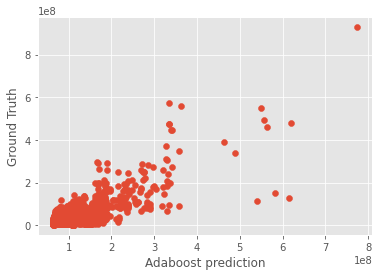

In [51]:
plt.scatter(ada_prediction, y_test)
plt.xlabel('Adaboost prediction')
plt.ylabel('Ground Truth')

# Gradient Boosting Machine

In [53]:
grad_boost_regr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [54]:
grad_boost_regr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.01, max_depth=9,
                          min_samples_leaf=2, min_samples_split=4,
                          n_estimators=2000, random_state=0)

In [55]:
gb_prediction = grad_boost_regr.predict(X_test)

In [88]:
gb_prediction

array([11214196.4400788 ,  7227579.05745758, 41775834.12136191, ...,
       12598655.14128944, 11670612.1717401 ,  9856988.76512617])

In [148]:
gb_mse = root_mean_squared_log_error(gb_prediction, y_test)
print('Gradient Boost MSE:', math.sqrt(gb_mse))

Gradient Boost MSE: 0.4187272673484639


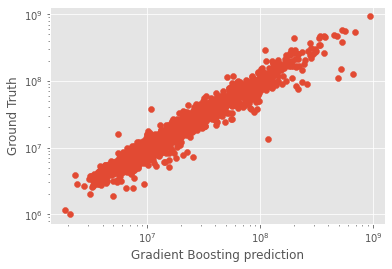

In [57]:
plt.scatter(gb_prediction, y_test)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')
plt.xscale('log')
plt.yscale('log')

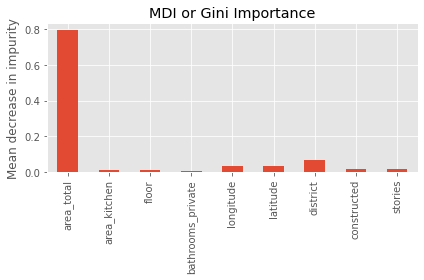

In [58]:
importances = grad_boost_regr.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# LightGBM

In [59]:
light_gbm = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [60]:
light_gbm.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.95, learning_rate=0.05, max_depth=5,
              metric='mse', n_estimators=2000, n_jobs=4, num_leaves=10,
              random_state=42, subsample=0.9)

In [100]:
lgbm_prediction = light_gbm.predict(X_test)

In [149]:
lgb_mse = root_mean_squared_log_error(np.abs(y_test), np.abs(lgbm_prediction))
print('LGBM MSE:', lgb_mse)

LGBM MSE: 0.27009139459664533


Text(0, 0.5, 'Ground Truth')

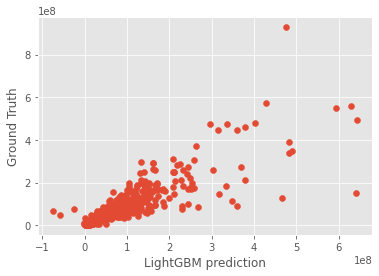

In [110]:
plt.scatter(lgbm_prediction, y_test)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')

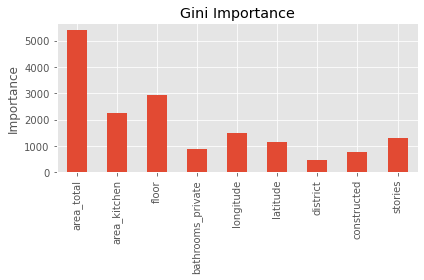

In [111]:
importances = light_gbm.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# CatBoost

In [112]:
catboost = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [113]:
catboost.fit(X_train, y_train)

In [114]:
cat_prediction = catboost.predict(X_test)

In [150]:
cat_mse = root_mean_squared_log_error(cat_prediction, y_test)
print('Catboost MSE:', cat_mse)

Catboost MSE: 0.21536234150804115


Text(0, 0.5, 'Ground Truth')

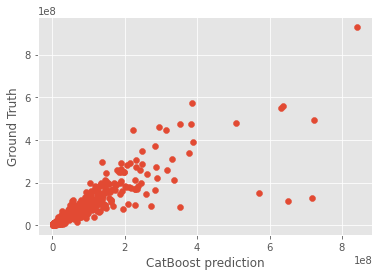

In [116]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

# Try gradient boost to obtain submission

In [ ]:
grad_boost_regr.fit(X, y)

In [ ]:
gb_prediction = grad_boost_regr.predict(processed_test)

In [ ]:
gb_prediction

In [ ]:
print(len(gb_prediction))
print(len(test))

In [ ]:
df = pd.DataFrame(gb_prediction, columns = ['price_prediction'])

In [ ]:
df

In [ ]:
result = pd.concat([test['id'], df], axis=1)

In [ ]:
result

In [ ]:
result[['id','price_prediction']].to_csv('submission.csv', index=False)

# Same for Catboost

In [152]:
catboost.fit(X, y)
cat_prediction = catboost.predict(processed_test)
df = pd.DataFrame(cat_prediction, columns = ['price_prediction'])
result = pd.concat([test['id'], df], axis=1)
result[['id','price_prediction']].to_csv('CB1.csv', index=False)

[28689792.53837101 30989777.67480221 61225477.62420059 ...
  9385962.26123848  9429313.03382172  5288718.14789962]
9937
9937


# Numerical + transform categorical

In [ ]:
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

## Categorical to numerical index map

In [145]:
le = LabelEncoder()
train_categorical_removed = train
train_categorical_removed['street'] = le.fit_transform(train_categorical_removed['street'])
train_categorical_removed['address'] = le.fit_transform(train_categorical_removed['address'])

In [146]:
train_categorical_removed

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.00,2.0,2.0,NaN,2.65,...,1714,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.60,17.0,1.0,NaN,2.65,...,1714,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.50,9.0,3.0,NaN,2.65,...,1714,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.30,9.0,1.0,NaN,2.65,...,1714,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.30,9.0,1.0,NaN,2.65,...,1714,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23228,0.0,12500000.0,73.0,14.5,24.16,2.0,2.0,1.0,2.90,...,756,2016.0,NaN,6.0,0.0,1.0,1.0,NaN,NaN,0.0
23281,23229,NaN,5250000.0,35.7,9.0,26.70,8.0,1.0,NaN,NaN,...,1443,1991.0,4.0,16.0,0.0,1.0,0.0,NaN,1.0,0.0
23282,23248,NaN,13500000.0,58.1,18.3,30.70,17.0,2.0,2.0,2.75,...,1471,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
23283,23250,1.0,18900000.0,116.0,12.6,NaN,2.0,3.0,NaN,NaN,...,1342,2001.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN


# Sequential models on `fillna(data.median())` + all and created features

## Prepare data 

In [160]:
processed_data
# processed_data contains all the data with interpolated (median) nan values

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.000000,7139520.0,59.2,12.5,31.000000,2.0,2.0,1.039695,2.650000,...,к2.5/2,2021.0,3.000000,9.0,0.00000,1.000000,1.000000,1.000000,0.806411,0.176012
1,12,3.000000,4045140.0,19.8,5.2,9.600000,17.0,1.0,1.039695,2.650000,...,к2.5/2,2021.0,3.000000,9.0,0.00000,1.000000,1.000000,1.000000,0.806411,0.176012
2,55,3.000000,9500240.0,79.7,17.0,41.500000,9.0,3.0,1.039695,2.650000,...,к2.5/2,2021.0,3.000000,9.0,0.00000,1.000000,1.000000,1.000000,0.806411,0.176012
3,104,3.000000,4326660.0,23.4,6.1,11.300000,9.0,1.0,1.039695,2.650000,...,к2.5/2,2021.0,3.000000,9.0,0.00000,1.000000,1.000000,1.000000,0.806411,0.176012
4,106,3.000000,4333980.0,23.8,6.1,11.300000,9.0,1.0,1.039695,2.650000,...,к2.5/2,2021.0,3.000000,9.0,0.00000,1.000000,1.000000,1.000000,0.806411,0.176012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23228,0.000000,12500000.0,73.0,14.5,24.160000,2.0,2.0,1.000000,2.900000,...,3,2016.0,2.203956,6.0,0.00000,1.000000,1.000000,0.572589,0.806411,0.000000
23281,23229,1.875683,5250000.0,35.7,9.0,26.700000,8.0,1.0,1.039695,3.268374,...,9,1991.0,4.000000,16.0,0.00000,1.000000,0.000000,0.572589,1.000000,0.000000
23282,23248,1.875683,13500000.0,58.1,18.3,30.700000,17.0,2.0,2.000000,2.750000,...,93К2,2011.0,3.000000,17.0,0.00000,1.000000,1.000000,0.572589,1.000000,0.000000
23283,23250,1.000000,18900000.0,116.0,12.6,38.741367,2.0,3.0,1.039695,3.268374,...,75,2001.0,2.203956,6.0,0.39262,0.929867,0.743109,0.572589,0.806411,0.176012


In [161]:
data_this_test = polar_coordinates(processed_data)
data_this_test['street'] = le.fit_transform(data_this_test['street'])
data_this_test['address'] = le.fit_transform(data_this_test['address'])

In [162]:
unwanted_features = ['longitude', 'latitude']
features_this_test = [el for el in all_features if el not in unwanted_features]
features_this_test += ['r', 'theta']

In [163]:
data_this_test.columns

Index(['apartment_id', 'seller', 'price', 'area_total', 'area_kitchen',
       'area_living', 'floor', 'rooms', 'layout', 'ceiling',
       'bathrooms_shared', 'bathrooms_private', 'windows_court',
       'windows_street', 'balconies', 'loggias', 'condition', 'phones',
       'building_id', 'new', 'latitude', 'longitude', 'district', 'street',
       'address', 'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating', 'r', 'theta'],
      dtype='object')

In [205]:
X = data_this_test[features_this_test]
y = data_this_test['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [217]:
print(features_this_test)

['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating', 'r', 'theta']


## Catboost

In [167]:
catboost.fit(X_train, y_train)
cat_prediction = catboost.predict(X_test)
cat_mse = root_mean_squared_log_error(cat_prediction, y_test)
print('Catboost MSE:', cat_mse)

Catboost MSE: 0.19711539316211263


Text(0, 0.5, 'Ground Truth')

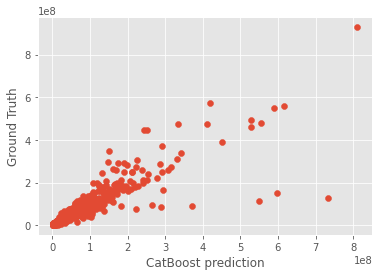

In [168]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

In [4]:
catboost_importance = catboost.get_feature_importance()
plot_feature_importance(catboost_importance, features_this_test, 'CatBoost: ')

NameError: name 'catboost' is not defined

### Submission Catboost with all features

In [207]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
print('app length', len(test_apartment))
print('buildings length', len(test_building))
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
print('merged length', len(test))
test.rename(columns={'id_x' : 'id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)

app length 9937
buildings length 2931
merged length 9937


In [208]:
X.rename(columns={'apartment_id' : 'id'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [210]:
processed_test = preprocess(test)
new_test_data = polar_coordinates(processed_test)

new_test_data['street'] = le.fit_transform(new_test_data['street'])
new_test_data['address'] = le.fit_transform(new_test_data['address'])

In [213]:
catboost.fit(X, y)
cat_prediction = catboost.predict(new_test_data)

In [215]:
df = pd.DataFrame(cat_prediction, columns = ['price_prediction'])
result = pd.concat([test['id'], df], axis=1)
result[['id','price_prediction']].to_csv('.\submissions\CB2.csv', index=False)

## Catboost select certain features

In [221]:
unwanted_features = ['longitude', 'latitude', 'new', 'elevator_passenger','seller','layout','phones','balconies',
                     'loggias','windows_court','windows_street','bathrooms_shared','apartment_id','material']
features_this_test = [el for el in all_features if el not in unwanted_features]
features_this_test += ['r', 'theta']
X = data_this_test[features_this_test]
y = data_this_test['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [225]:
catboost.fit(X_train, y_train)
cat_prediction = catboost.predict(X_test)
cat_mse = root_mean_squared_log_error(np.abs(cat_prediction), y_test)
print('Catboost MSE:', cat_mse)

Catboost MSE: 0.19450430709257754


Text(0, 0.5, 'Ground Truth')

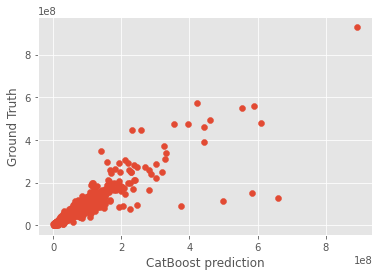

In [226]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

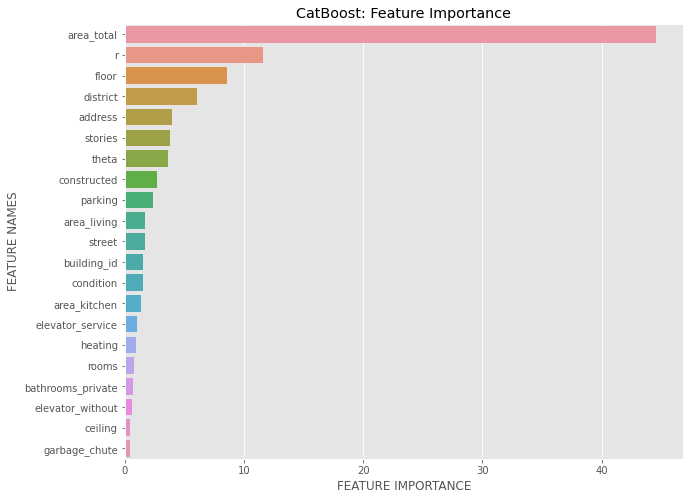

In [227]:
catboost_importance = catboost.get_feature_importance()
plot_feature_importance(catboost_importance, features_this_test, 'CatBoost: ')

### Submission select certain features

In [235]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
X.rename(columns={'apartment_id' : 'id'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
processed_test = preprocess(test)
new_test_data = polar_coordinates(processed_test)

new_test_data['street'] = le.fit_transform(new_test_data['street'])
new_test_data['address'] = le.fit_transform(new_test_data['address'])

new_test_data = new_test_data[features_this_test]

NameError: name 'test' is not defined

In [237]:
catboost.fit(X, y)
cat_prediction = catboost.predict(new_test_data)

In [238]:
df = pd.DataFrame(cat_prediction, columns = ['price_prediction'])
result = pd.concat([test['id'], df], axis=1)
result[['id','price_prediction']].to_csv('.\submissions\CB3.csv', index=False)

In [239]:
print(features_this_test)

['area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_private', 'condition', 'building_id', 'district', 'street', 'address', 'constructed', 'stories', 'elevator_without', 'elevator_service', 'parking', 'garbage_chute', 'heating', 'r', 'theta']
